# SkimLit Project 📄

We’re replicating the deep learning model from [PubMed 200k RCT: A Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). This dataset contains 200,000 labeled RCT abstracts and aims to classify the role of each sentence (e.g., objective, methods, results).

### Problem:  
RCT abstracts without structure slow down research.

### Solution:  
Build an NLP model to label each sentence in an abstract, helping researchers quickly skim key info.

### What We’ll Cover:
- Downloading and preprocessing the dataset
- Building a baseline model
- Experimenting with deep models


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import helper_functions
import requests

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
response = requests.get(url)

# Save the file locally
with open('helper_functions.py', 'wb') as file:
    file.write(response.content)

print("Download complete!")

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys, calculate_results

Download complete!


In [3]:
# Clone the GitHub repository containing the PubMed RCT dataset
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [4]:
# Import the os module to interact with the operating system
import os

# Print the contents of the 'pubmed-rct' directory
print(os.listdir('pubmed-rct'))

['.git', 'PubMed_200k_RCT', 'PubMed_200k_RCT_numbers_replaced_with_at_sign', 'PubMed_20k_RCT', 'PubMed_20k_RCT_numbers_replaced_with_at_sign', 'README.md']


In [5]:
print(os.listdir('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'))

['dev.txt', 'test.txt', 'train.txt']


In [6]:
data_dir = "pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
# Check all the filenames in the directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [8]:
# Create a function to read the lines in the document

def get_lines(filename):

    with open(filename, "r") as f:
        return f.readlines()

In [9]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

In [11]:
test_lines = get_lines(data_dir + "test.txt")
len(test_lines)

35135

```python
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 ...]
```


#### Write function to turn each datasets into the above format

In [12]:
# Define a function to preprocess the text data with line numbers
def preprocess_text_with_line_numbers(filename):
    # Read the lines from the file
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    # Iterate over each line in the input
    for line in input_lines:
        # If the line starts with "###", it indicates the start of a new abstract
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        # If the line is empty, it indicates the end of an abstract
        elif line.isspace():
            # Split the abstract lines into individual lines
            abstract_line_split = abstract_lines.splitlines()

            # Iterate over each line in the abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                # Split the line into target and text
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)
                abstract_samples.append(line_data)

        # If the line is neither a new abstract nor an empty line, it's part of the abstract
        else:
            abstract_lines += line

    # Return the preprocessed abstract samples
    return abstract_samples

In [13]:
%%time

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: total: 78.1 ms
Wall time: 366 ms


In [14]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [15]:
# Import pandas as pd
import pandas as pd

#  Create dataframes for the training, validation, and test samples
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [16]:
train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [17]:
# Convert the 'text' column of the dataframes to lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

# Display the first 10 sentences from the training sentences list
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

In [18]:
# Import the OneHotEncoder class from sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder class with sparse=False
one_hot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the 'target' column of the training dataframe to obtain one-hot encoded labels
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))

# Fit and transform the 'target' column of the validation dataframe to obtain one-hot encoded labels
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

# Fit and transform the 'target' column of the test dataframe to obtain one-hot encoded labels
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# Display the one-hot encoded labels for the training samples
train_labels_one_hot

d:\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
# Import the LabelEncoder class from sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder class
label_encoder = LabelEncoder()

# Fit and transform the 'target' column of the training dataframe to obtain encoded labels
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())

# Fit and transform the 'target' column of the validation dataframe to obtain encoded labels
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())

# Fit and transform the 'target' column of the test dataframe to obtain encoded labels
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Display the encoded labels for the training samples
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names 
class_names = label_encoder.classes_
# get number of classes
num_classes = len(class_names)

class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

# Model 0 : Baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text data to TF-IDF features
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier for text classification
from sklearn.pipeline import Pipeline  # Pipeline to chain multiple steps together

# Create a pipeline that first converts text to TF-IDF features, then applies the Naive Bayes classifier
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # Step 1: Convert the input text into a TF-IDF matrix
    ("clf", MultinomialNB())        # Step 2: Apply the Multinomial Naive Bayes classifier
])

# Fit the pipeline to the training data (train_sentences) and their corresponding labels (train_labels_encoded)
model_0.fit(X=train_sentences, y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate the model's performance on the validation set (val_sentences and val_labels_encoded)
# The score method returns the accuracy of the model
model_0.score(X=val_sentences, 
              y=val_labels_encoded)


0.7218323844829869

In [23]:
# Use the trained model to make predictions on the validation data (val_sentences)
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Assuming calculate_results is a custom function to evaluate model performance
baseline_results = calculate_results(y_true=val_labels_encoded,  # True labels from the validation set
                                     y_pred=baseline_preds)      # Predicted labels from the model
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Prepare the data

In [25]:
# Average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

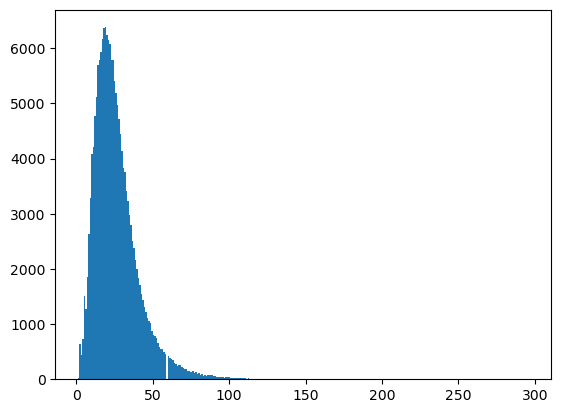

In [26]:
plt.hist(sent_lens, bins = 300);

In [27]:
# Calculate the length that covers 95% of sentences 
output_seq_len = np.percentile(sent_lens, 95)
output_seq_len

55.0

### Create text vectorization

In [28]:
# Number of words are in our vocabulary (taken from Table 2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

# Create a TextVectorization layer to vectorize the text 
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=int(output_seq_len))

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
# Randomly select a sentence from the training data and display its text, length, and vectorized form
import random
target_sentence = random.choice(train_sentences)
print(f"Text : {target_sentence}")
print(f"Length of text : {len(target_sentence.split())}")
print(f"Vectorized text : {text_vectorizer([target_sentence])}")


Text : mean ( sd ) z-scores were -@ ( @ ) at the spine and -@ ( @ ) for total hip ; @ % had osteoporosis and @ % had low bmd ( hip or spine t-score < -@ ) .
Length of text : 41
Vectorized text : [[  57  357 6850    9   15    2 1559    3   11   76  962   55 2858    3
    55  220 1438  962   16 1559 9522    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [32]:
# Get the vocabulary from the TextVectorization layer and display vocabulary stats
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create text embedding

In [34]:
# Create an embedding layer for token embeddings
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),  # Size of the vocabulary (number of unique tokens)
    output_dim=128,                     # Dimensionality of the embedding vectors (each token will be represented by a 128-dimensional vector)
    mask_zero=True,                     # Mask the zero input (padding) during training
    name="token_embedding"              
)


In [35]:
# Print the original sentence before vectorization
print(f"Sentence before vectorization: {target_sentence}")

# Print the vectorized representation of the sentence using the text vectorizer
print(f"Vectorized sentence: {text_vectorizer([target_sentence])}")

# Print the embedded representation of the vectorized sentence using the embedding layer
# The vectorized sentence is passed through the token_embed layer to get the embeddings
print(f"Embedded sentence: {token_embed(text_vectorizer([target_sentence]))}")

# Print the shape of the embedded sentence
print(f"Embedded sentence shape: {token_embed(text_vectorizer([target_sentence])).shape}")


Sentence before vectorization: mean ( sd ) z-scores were -@ ( @ ) at the spine and -@ ( @ ) for total hip ; @ % had osteoporosis and @ % had low bmd ( hip or spine t-score < -@ ) .
Vectorized sentence: [[  57  357 6850    9   15    2 1559    3   11   76  962   55 2858    3
    55  220 1438  962   16 1559 9522    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Embedded sentence: [[[ 0.02804511  0.00216337  0.01362428 ...  0.02263042 -0.01673182
    0.02807507]
  [ 0.04222692 -0.03903262  0.02028099 ... -0.0181371   0.00615548
    0.04967097]
  [ 0.03488031  0.04656309 -0.02858492 ... -0.01999034 -0.01283202
   -0.02574279]
  ...
  [-0.02608505  0.03033227  0.00554783 ... -0.02672386  0.04476224
   -0.00254921]
  [-0.02608505  0.03033227  0.00554783 ... -0.02672386  0.04476224
   -0.00254921]
  [-0.02608505  0.03033227  0.00554783 ... -0.02672386  0.04476224
   -0.

In [36]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [38]:
# Create a model
inputs = layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(num_classes,
                       activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_1.summary()

C:\Users\ziyad\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Fit
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data= val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5273 - loss: 1.1519 - val_accuracy: 0.7407 - val_loss: 0.6937
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7446 - loss: 0.6829 - val_accuracy: 0.7676 - val_loss: 0.6295
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7686 - loss: 0.6240 - val_accuracy: 0.7872 - val_loss: 0.5932


In [40]:
# Evaluate
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7851 - loss: 0.5980


[0.5998997092247009, 0.7850192189216614]

In [41]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:3], model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[4.1804743e-01, 1.8249711e-01, 8.6784340e-02, 2.7875549e-01,
         3.3915710e-02],
        [4.4165808e-01, 2.9705742e-01, 9.7922496e-03, 2.4276355e-01,
         8.7286290e-03],
        [1.4368241e-01, 5.6756097e-03, 1.7424950e-03, 8.4885633e-01,
         4.3138141e-05]], dtype=float32),
 (30212, 5))

In [42]:
model_1_preds = model_1_pred_probs.argmax(axis=1)
model_1_preds

array([0, 0, 3, ..., 4, 4, 1], dtype=int64)

In [43]:
model_1_results = calculate_results(val_labels_encoded,
                                   model_1_preds)
model_1_results

{'accuracy': 78.50191976698001,
 'precision': 0.7812818170830635,
 'recall': 0.7850191976698001,
 'f1': 0.7823679012958423}

# Model 2: Feature extraction with pretrained token embeddings

 [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4)

In [44]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0]}")
print(f"length: {len(use_embedded_sentence[0])}")

Random sentence: for mcp joints , there were no significant differences in flexion contractures between @ - and @-day cohorts for initial ( @ vs @ ) , postmanipulation ( @ vs @ ) , or @-day follow-up ( @ vs @ ) measurements .



Sentence after embedding: [-0.06323966 -0.08103918 -0.03610609 -0.02834712  0.00024353  0.02803773
 -0.00861056 -0.02615365 -0.02575081  0.07840681 -0.00617412 -0.02647843
  0.00477582 -0.00112836 -0.00768207  0.02600395 -0.0088594   0.01789286
  0.06484473 -0.03073029  0.08889813  0.05678758 -0.02640342  0.04047905
 -0.0036025   0.0259309  -0.025872    0.05556148 -0.03495395  0.00207194
  0.01978148 -0.01678724  0.05402088 -0.00203427 -0.02916239  0.05411584
 -0.04197153  0.00855626  0.01413929 -0.0700752  -0.05556852  0.05248371
 -0.04703125 -0.04710577  0.01398434  0.05015658  0.02317614 -0.02131013
  0.02537024  0.0025795  -0.04644776  0.05272158 -0.01360586 -0.06491656
  0.02849559 -0.0138868  -0.06763873  0.07308615 -0.06431175 -0.01752219
 -0.00589748 -0.02709687  0.03995559 -0.05153052  0.00861473  0.00077667
 -0.00737446  0.01323797  0.06821509 -0.06401625 -0.00940344 -0.03724542
 -0.04185706 -0.01033378 -0.0561315   0.03150278 -0.06305078  0.02033438
  0.0712237   0.02913489 

### Build and fit NLP feature extraction model using pretrained embeddings

In [46]:
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.encoder = hub_layer
 
    def call(self, inputs):
        return self.encoder(inputs)
    
use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer)

In [47]:
inputs = layers.Input( shape= [], dtype= tf.string)

pretrained_model = use_layer(inputs)
x = layers.Dense(128, activation= "relu")(pretrained_model)

outputs = layers.Dense(num_classes, activation= "softmax")(x)

model_2 = tf.keras.Model(inputs,
                         outputs)


# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics= ["accuracy"])


model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ universal_sentence_encoder_lay… │ (None, 512)            │             0 │
│ (UniversalSentenceEncoderLayer) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Fit
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data= val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5814 - loss: 1.0956 - val_accuracy: 0.6895 - val_loss: 0.7963
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7031 - loss: 0.7713 - val_accuracy: 0.7098 - val_loss: 0.7558
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7133 - loss: 0.7538 - val_accuracy: 0.7214 - val_loss: 0.7281


In [49]:
# Evaluate
model_2.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7150 - loss: 0.7382


[0.7395379543304443, 0.7140871286392212]

In [50]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs[:3], model_2_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


(array([[0.39930752, 0.40573812, 0.00304871, 0.18231405, 0.00959163],
        [0.36155918, 0.4952686 , 0.00436077, 0.13621847, 0.00259299],
        [0.22865081, 0.12276874, 0.01939276, 0.59457576, 0.03461196]],
       dtype=float32),
 (30212, 5))

In [51]:
model_2_preds = model_2_pred_probs.argmax(axis=1)
model_2_preds

array([1, 1, 3, ..., 4, 4, 2], dtype=int64)

In [52]:
model_2_results = calculate_results(val_labels_encoded,
                                   model_2_preds)
model_2_results

{'accuracy': 71.40871177015755,
 'precision': 0.7144988590569437,
 'recall': 0.7140871177015755,
 'f1': 0.7111975420397609}

# Model 3: Conv1D with character embeddings 

In [53]:
# Function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

In [54]:
split_chars(random_train_sentence)

'f o r   m c p   j o i n t s   ,   t h e r e   w e r e   n o   s i g n i f i c a n t   d i f f e r e n c e s   i n   f l e x i o n   c o n t r a c t u r e s   b e t w e e n   @   -   a n d   @ - d a y   c o h o r t s   f o r   i n i t i a l   (   @   v s   @   )   ,   p o s t m a n i p u l a t i o n   (   @   v s   @   )   ,   o r   @ - d a y   f o l l o w - u p   (   @   v s   @   )   m e a s u r e m e n t s   .'

In [55]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [56]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

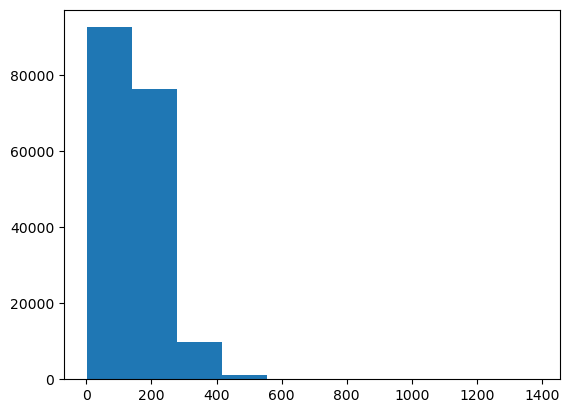

In [57]:
plt.hist(char_lens);

In [58]:
# Calculate the length that covers 95% of sequences
output_seq_char_len = np.percentile(char_lens, 95)
output_seq_char_len

290.0

In [59]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [60]:
num_char_tokens = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                    output_sequence_length=int(output_seq_char_len))

In [61]:
# Adapt
char_vectorizer.adapt(train_chars)

In [62]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocabulary: {len(char_vocab)}")
print(f"Most common characters in the vocabulary: {char_vocab[:5]}")
print(f"Least common characters in the vocabulary: {char_vocab[-5:]}")

Number of characters in vocabulary: 28
Most common characters in the vocabulary: ['', '[UNK]', 'e', 't', 'i']
Least common characters in the vocabulary: ['k', 'x', 'z', 'q', 'j']


In [63]:
target_chars = random.choice(train_chars)
print(f"Text : {target_chars}")
print(f"Length of chars : {len(target_chars.split())}")
print(f"Vectorized chars : {char_vectorizer([target_chars])[0]}")
print(f"len: {len(char_vectorizer([target_chars])[0])}")

Text : t i m e   f o r   c o m p l e t e   r e s p o n s e   w a s   s i g n i f i c a n t l y   s h o r t e r   (   p   =   @   ;   l o g - r a n k   t e s t   )   i n   t h e   r s k   g r o u p   (   m e d i a n   :   @   d   ;   @   %   c i   :   @ - @   @   )   w i t h   r e s p e c t   t o   t h e   a c t i v e   c o n t r o l   (   m e d i a n   :   @   d   ;   @   %   c i   :   @ - @   @   )   .
Length of chars : 149
Vectorized chars : [ 3  4 15  2 17  7  8 11  7 15 14 12  2  3  2  8  2  9 14  7  6  9  2 20
  5  9  9  4 18  6  4 17  4 11  5  6  3 12 19  9 13  7  8  3  2  8 14 12
  7 18  8  5  6 23  3  2  9  3  4  6  3 13  2  8  9 23 18  8  7 16 14 15
  2 10  4  5  6 10 11  4 20  4  3 13  8  2  9 14  2 11  3  3  7  3 13  2
  5 11  3  4 21  2 11  7  6  3  8  7 12 15  2 10  4  5  6 10 11  4  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [64]:
char_embed = layers.Embedding(
    input_dim=len(char_vocab),  
    output_dim=25,                     
    mask_zero=True,                    
    name="char_embed"              
)

In [65]:
print(f"chars before vectorization: {target_chars}")
print(f"Embedded chars: {char_embed(char_vectorizer([target_chars]))}")
print(f"Embedded chars shape: {char_embed(char_vectorizer([target_chars])).shape}")


chars before vectorization: t i m e   f o r   c o m p l e t e   r e s p o n s e   w a s   s i g n i f i c a n t l y   s h o r t e r   (   p   =   @   ;   l o g - r a n k   t e s t   )   i n   t h e   r s k   g r o u p   (   m e d i a n   :   @   d   ;   @   %   c i   :   @ - @   @   )   w i t h   r e s p e c t   t o   t h e   a c t i v e   c o n t r o l   (   m e d i a n   :   @   d   ;   @   %   c i   :   @ - @   @   )   .
Embedded chars: [[[-0.004449    0.04220705  0.00623484 ... -0.014144    0.03301371
   -0.01011457]
  [-0.00724715  0.01506561 -0.00375758 ...  0.01386753  0.03865753
    0.03971172]
  [ 0.00317482  0.00483185  0.04907671 ... -0.02069082  0.01788065
   -0.04763376]
  ...
  [ 0.03392217  0.02813337  0.00968758 ... -0.0445621  -0.01780175
    0.02247355]
  [ 0.03392217  0.02813337  0.00968758 ... -0.0445621  -0.01780175
    0.02247355]
  [ 0.03392217  0.02813337  0.00968758 ... -0.0445621  -0.01780175
    0.02247355]]]
Embedded chars shape: (1, 290, 25)


In [66]:
# Create a model
inputs = layers.Input(shape=(1,), dtype=tf.string)

char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(num_classes,
                       activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_3.summary()

C:\Users\ziyad\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [68]:
# Prefetch
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [69]:
# Fit
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data= val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4186 - loss: 1.3917 - val_accuracy: 0.5894 - val_loss: 1.0286
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5877 - loss: 1.0257 - val_accuracy: 0.6250 - val_loss: 0.9473
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6320 - loss: 0.9372 - val_accuracy: 0.6499 - val_loss: 0.8937


In [70]:
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6546 - loss: 0.8866


[0.8886808156967163, 0.6540116667747498]

In [71]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:3], model_3_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[0.17931426, 0.4833627 , 0.08560666, 0.20929927, 0.04241716],
        [0.28735012, 0.5349649 , 0.02313679, 0.1228551 , 0.03169317],
        [0.1434316 , 0.34201553, 0.33187994, 0.0945625 , 0.08811048]],
       dtype=float32),
 (30212, 5))

In [72]:
model_3_preds = model_3_pred_probs.argmax(axis=1)
model_3_preds

array([1, 1, 1, ..., 4, 4, 0], dtype=int64)

In [73]:
model_3_results = calculate_results(val_labels_encoded,
                                   model_3_preds)
model_3_results

{'accuracy': 65.40116509996028,
 'precision': 0.6492696224932156,
 'recall': 0.6540116509996028,
 'f1': 0.6442345470834366}

# Model 4: Combining pretrained token embeddings (model 1) + character embeddings (model 3)

In [74]:
from tensorflow.keras import layers
import tensorflow as tf

In [75]:
# Token input/model
token_inputs = layers.Input( shape= [], dtype= tf.string)
token_pretrained_model = use_layer(token_inputs)
token_outputs = layers.Dense(128, activation= "relu")(token_pretrained_model)
token_model = tf.keras.Model(token_inputs,
                         token_outputs)

# Char input/model
char_inputs = layers.Input( shape= [], dtype= tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                         char_bi_lstm)
# Concatenate both
token_char_concat = layers.concatenate([token_model.output,
                                          char_model.output])
# Create output layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct model char and token are inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)

model_4.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 290)       │          0 │ input_layer_4[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ input_layer_3[0]… │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 290)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[1][0], │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 176)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 176)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │     35,400 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │      1,005 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,369 (438.94 KB)

 Trainable params: 112,369 (438.94 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Compile
model_4.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [77]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)



val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [78]:
# Fit
history_model_4 = model_4.fit(train_token_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              validation_data= val_token_char_dataset,
                              validation_steps = int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.5386 - loss: 1.1330 - val_accuracy: 0.6961 - val_loss: 0.7740
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.6936 - loss: 0.7975 - val_accuracy: 0.7317 - val_loss: 0.7105
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.7020 - loss: 0.7703 - val_accuracy: 0.7311 - val_loss: 0.6840


In [79]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_preds = model_4_pred_probs.argmax(axis=1)
model_4_results = calculate_results(val_labels_encoded,
                                  model_4_preds)
model_4_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step


{'accuracy': 73.5833443664769,
 'precision': 0.7368249471871104,
 'recall': 0.735833443664769,
 'f1': 0.7337706391503815}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

### Create positional embeddings

In [80]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [81]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

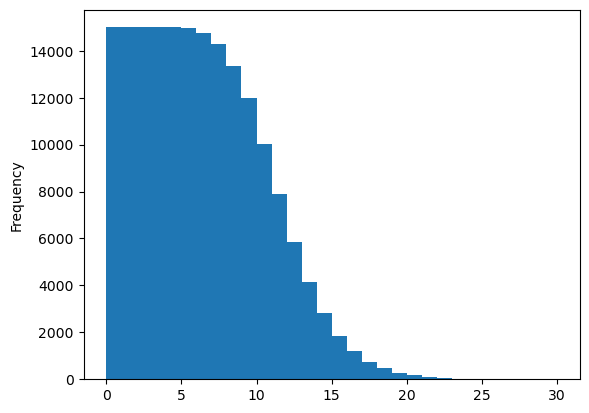

In [90]:
train_df["line_number"].plot.hist(bins= 30);

In [116]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:17], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(17, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [140]:
train_df["total_lines"].value_counts()

total_lines
12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: count, dtype: int64

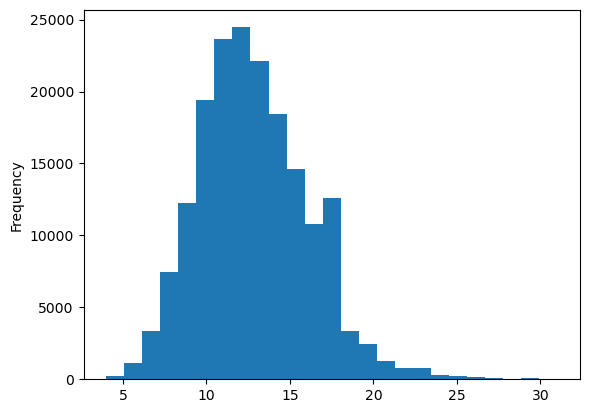

In [142]:
train_df["total_lines"].plot.hist(bins= 25);

In [146]:
np.percentile(train_df["total_lines"], 98)

21.0

In [148]:
train_total_line_numbers_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=21)
val_total_line_numbers_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=21)
test_total_line_numbers_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=21)
train_total_line_numbers_one_hot[:5], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(5, 21), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

In [149]:
train_line_numbers_one_hot[0]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [150]:
train_total_line_numbers_one_hot[0]

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)>

In [157]:
# Token input/model
token_inputs = layers.Input( shape= [], dtype= tf.string)
token_pretrained_model = use_layer(token_inputs)
token_outputs = layers.Dense(128, activation= "relu")(token_pretrained_model)
token_model = tf.keras.Model(token_inputs,
                         token_outputs)

# Char input/model
char_inputs = layers.Input( shape=(1, ), dtype= tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                         char_bi_lstm)


# Line numbers model
line_number_inputs = layers.Input( shape=(15, ), dtype= tf.float32)
x = layers.Dense(32, activation= "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   x)

# Total lines model
total_lines_inputs = layers.Input( shape=(21, ), dtype= tf.float32)
y = layers.Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                   y)


# combine token and char embeddings
combined_embeddings = layers.concatenate([token_model.output,
                                          char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z) 

# combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.concatenate([line_number_model.output,
                                          total_lines_model.output,
                                          z])

# Create output layer
output_layer = layers.Dense(num_classes, activation="softmax")(tribrid_embeddings)

# Construct model char and token are inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

model_5.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 290)       │          0 │ input_layer_26[0… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ input_layer_25[0… │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 290)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 48)        │      9,600 │ char_embed[7][0], │
│ (Bidirectional)     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 176)       │          0 │ dense_32[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_28      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 256)       │     45,312 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 32)        │        512 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │        704 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 320)       │          0 │ dense_33[0][0],   │
│ (Concatenate)       │                   │            │ dense_34[0][0],   │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 5)         │      1,605 │ concatenate_12[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,097 (484.75 KB)

 Trainable params: 124,097 (484.75 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# Compile
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [159]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_line_numbers_one_hot, train_sentences, train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)



val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_line_numbers_one_hot,val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_line_numbers_one_hot,test_sentences, test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [160]:
# Fit
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              validation_data= val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 46s 75ms/step - accuracy: 0.6155 - loss: 1.2328 - val_accuracy: 0.8088 - val_loss: 0.9834
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8098 - loss: 0.9736 - val_accuracy: 0.8291 - val_loss: 0.9396
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.8174 - loss: 0.9538 - val_accuracy: 0.8351 - val_loss: 0.9322


In [161]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = model_5_pred_probs.argmax(axis=1)
model_5_results = calculate_results(val_labels_encoded,
                                  model_5_preds)
model_5_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step


{'accuracy': 83.57937243479412,
 'precision': 0.8346401801784312,
 'recall': 0.8357937243479412,
 'f1': 0.8346829334817061}

# Compare model results

In [212]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.785019,0.781282,0.785019,0.782368
pretrained_token_embed,0.714087,0.714499,0.714087,0.711198
custom_char_embed_conv1d,0.654012,0.649270,0.654012,0.644235
hybrid_char_token_embed,0.735833,0.736825,0.735833,0.733771
tribrid_pos_char_token_embed,0.835794,0.834640,0.835794,0.834683


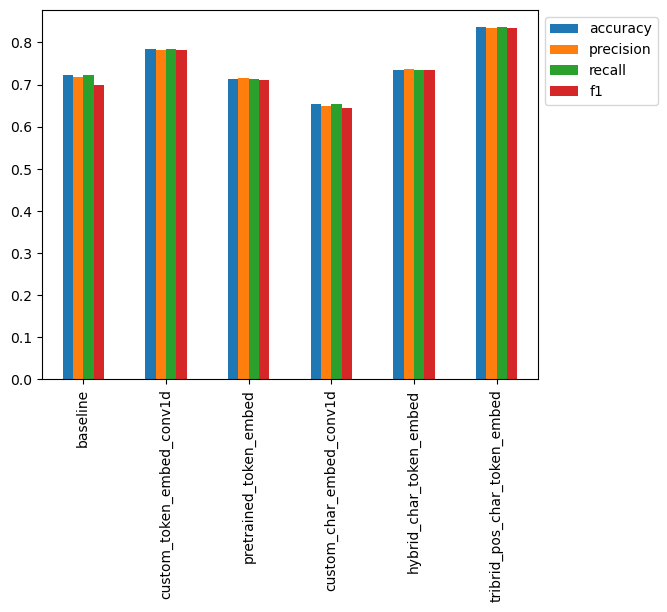

In [213]:
all_model_results.plot.bar().legend(bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'f1')

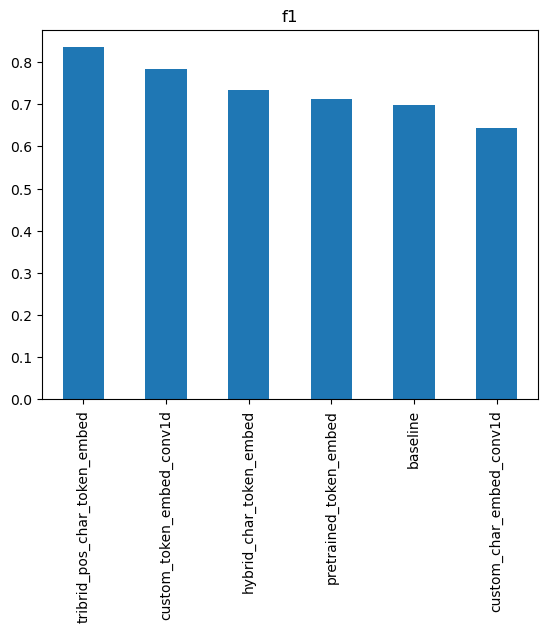

In [214]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot.bar()
plt.title("f1")

In [231]:
model_5.export("skimlit_model")

INFO:tensorflow:Assets written to: skimlit_model\assets


INFO:tensorflow:Assets written to: skimlit_model\assets


Saved artifact at 'skimlit_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 15), dtype=tf.float32, name='keras_tensor_124'), TensorSpec(shape=(None, 21), dtype=tf.float32, name='keras_tensor_126'), TensorSpec(shape=(None,), dtype=tf.string, name='keras_tensor_116'), TensorSpec(shape=(None, 1), dtype=tf.string, name='keras_tensor_119')]
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2999475601232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2999475601040: TensorSpec(shape=(), dtype=tf.int64, name=None)
  2999475598928: TensorSpec(shape=(), dtype=tf.string, name=None)
  2999475598352: TensorSpec(shape=(), dtype=tf.int64, name=None)
  2999475600848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2995823568144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2995823567952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2995823567760: TensorSpec(shape=(),